In [28]:
import pickle
import os
from collections import Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

sns.set()
plt.rcParams.update({'font.size': 22})

In [29]:
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
def find(lst, s):
    return [i for i, x in enumerate(lst) if x==s]

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [30]:
d = 'm5'

In [31]:
def plot_results(df, err_metric='mase'):
    _, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax = ax.ravel()
    transf = df.transformation.unique()
    transf.sort()
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', y=err_metric, hue='group', marker='o', data=df.loc[df['transformation']==transf[i]].sort_values(['version', 'group']), ax=ax[i])
        ax[i].set_ylim(0, 6.0)
        ax[i].set_title(transf[i], fontsize=22)
        
def plot_results_perc_diff(df):
    _, ax = plt.subplots(2, 2, figsize=(20, 20))
    ax = ax.ravel()
    transf = df.transformation.unique()
    transf.sort()
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', 
                          y='pct_change', 
                          hue='group', 
                          marker='o', 
                          data=df.loc[df['transformation']==transf[i]].sort_values(['version', 'group']), 
                          ax=ax[i])
        ax[i].set_ylim(-0.5, 2.5)
        ax[i].set_title(transf[i], fontsize=22)
        
def plot_results_joint(df1, df2, df3, err_metric='mase'):
    
    if err_metric=='mase':
        ylim=(0, 6)
    elif err_metric=='rmse':
        ylim=(0, 15000)
    elif err_metric=='pct_change':
        ylim=(-0.5, 2.5)
    elif err_metric=='rel_change':
        ylim=(-1, 3.5)
        
    _, ax = plt.subplots(4, 3, figsize=(40, 20))
    transf = df1.transformation.unique()
    transf.sort()
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', 
                          y=err_metric, 
                          hue='group', 
                          marker='o', 
                          data=df1.loc[df1['transformation']==transf[i]].sort_values(['version', 'group']), 
                          ax=ax[i, 0])
        ax[i,0].set_ylim(*ylim)
        ax[i,0].set_title(transf[i], fontsize=22)

    transf = df2.transformation.unique()
    transf.sort()
    for i in range(len(transf)):

        fg = sns.lineplot(x='version', 
                          y=err_metric, 
                          hue='group', 
                          marker='o', 
                          data=df2.loc[df2['transformation']==transf[i]].sort_values(['version', 'group']), 
                          ax=ax[i,1])        
        ax[i,1].set_ylim(*ylim)
        ax[i,1].set_title(transf[i], fontsize=22)
    
    transf = df3.transformation.unique()
    transf.sort()  
    for i in range(len(transf)):
        fg = sns.lineplot(x='version', 
                          y=err_metric, 
                          hue='group', 
                          marker='o', 
                          data=df3.loc[df3['transformation']==transf[i]].sort_values(['version', 'group']), 
                          ax=ax[i,2])        
        ax[i,2].set_ylim(*ylim)
        ax[i,2].set_title(transf[i], fontsize=22)
        
    plt.tight_layout()

In [32]:
def compute_aggreated_results_dict(algorithm, dataset, path='../results', err_metric='mase'):
    results_dict={}
    for file in [path for path in os.listdir(path) if algorithm in path and dataset in path]:
        with open(f'{path}/{file}', 'rb') as handle:
            flatten_file_name = list(flatten([i.split('.') for i in file.split('_')]))
            idx_dataset_name = find(flatten_file_name, dataset)[0]
            sample = flatten_file_name[idx_dataset_name+1:-1][-1]
            version = flatten_file_name[idx_dataset_name+1:-1][-2]
            transformation = '_'.join(flatten_file_name[idx_dataset_name+1:-1][:-2])
            if not keys_exists(results_dict, transformation):
                results_dict[transformation] = {}
            if not keys_exists(results_dict, transformation, version): 
                results_dict[transformation][version] = {}
            if not keys_exists(results_dict, transformation, version, sample):    
                results_dict[transformation][version][sample] = {}
                
            results_dict_temp = copy.deepcopy(results_dict)
            results_dict_temp[transformation][version][sample] = pickle.load(handle)

            results_dict[transformation][version][sample][err_metric] = {}

            # We are getting the results for each group as lists and we want to store it 
            # as objects such as {'mase': {bottom_ind_1: value}, {bottom_ind_2: value}}
            for (k,v_) in results_dict_temp[transformation][version][sample][err_metric].items():
                # if it is the original versions we only want to get the individual results
                if not isinstance(v_, np.ndarray):
                    results_dict[transformation][version][sample][err_metric][f'{k}'] = v_
        handle.close()
    return results_dict

In [33]:
def compute_aggregated_results_df(results_dict, err_metric='rmse'):
    # shape=(transformation, version, sample, metric, dim)
    # metric = mase, rmse
    # dim = bottom, total, state, gender, legal, all

    df = pd.DataFrame.from_dict({(i,j, k, l): results_dict[i][j][k][l] 
                               for i in results_dict.keys() 
                               for j in results_dict[i].keys()
                               for k in results_dict[i][j].keys()
                               for l in results_dict[i][j][k].keys()},
                           orient='index')

    df_err = df[np.in1d(df.index.get_level_values(3), [err_metric])]
    df_clean = df_err.mean(level=(0,1,2)).stack(level=0).to_frame()
    df_clean = df_clean.reset_index()
    df_clean.columns = ['transformation', 'version', 'sample', 'group', err_metric]
    
    return df_clean
    
def compute_new_metrics(df_clean, err_metric='rmse'):
    # Calculate percentage change
    df = df_clean.copy()
    s = df.set_index(['transformation', 'version', 'sample', 'group'])[err_metric].unstack('version')
    df = df.set_index(['transformation', 'version', 'sample', 'group'])
    df_pct = pd.DataFrame(s.div(s['orig'].groupby(['transformation', 'group']).transform(lambda x: x.fillna(x.sum())), axis='rows').sub(1).stack()).reset_index().set_index(['transformation', 'version', 'sample', 'group'])
    df_pct = df_pct.rename(columns={0: 'pct_change'})
    df_updated = df.merge(df_pct, how='left', left_index=True, right_index=True)
    
    # Calculate relative change
    df = df_clean.copy()
    s = df.set_index(['transformation', 'version', 'sample', 'group'])[err_metric].unstack('version')
    df = df.set_index(['transformation', 'version', 'sample', 'group'])
    df_rel = pd.DataFrame(s.sub(s['orig']
                                .groupby(['transformation', 'group'])
                                .transform(lambda x: x.fillna(x.sum())), axis='rows')
                          .stack()).reset_index().set_index(['transformation', 'version', 'sample', 'group'])
    df_rel = df_rel.rename(columns={0: 'rel_change'})
    df_new = df_updated.merge(df_rel, how='left', left_index=True, right_index=True)
    df_new = df_new.reset_index()
    
    return df_new

In [34]:
dict_gpf = compute_aggreated_results_dict(algorithm='gpf', dataset=d, err_metric='rmse')
df_gpf = compute_aggregated_results_df(dict_gpf)
df_gpf_rmse = compute_new_metrics(df_gpf)
dict_mint = compute_aggreated_results_dict(algorithm='mint', dataset=d, err_metric='rmse')
df_mint = compute_aggregated_results_df(dict_mint)
df_mint_rmse = compute_new_metrics(df_mint)
dict_deepar = compute_aggreated_results_dict(algorithm='deepar', dataset=d, err_metric='rmse')
df_deepar = compute_aggregated_results_df(dict_deepar)
df_deepar_rmse = compute_new_metrics(df_deepar)

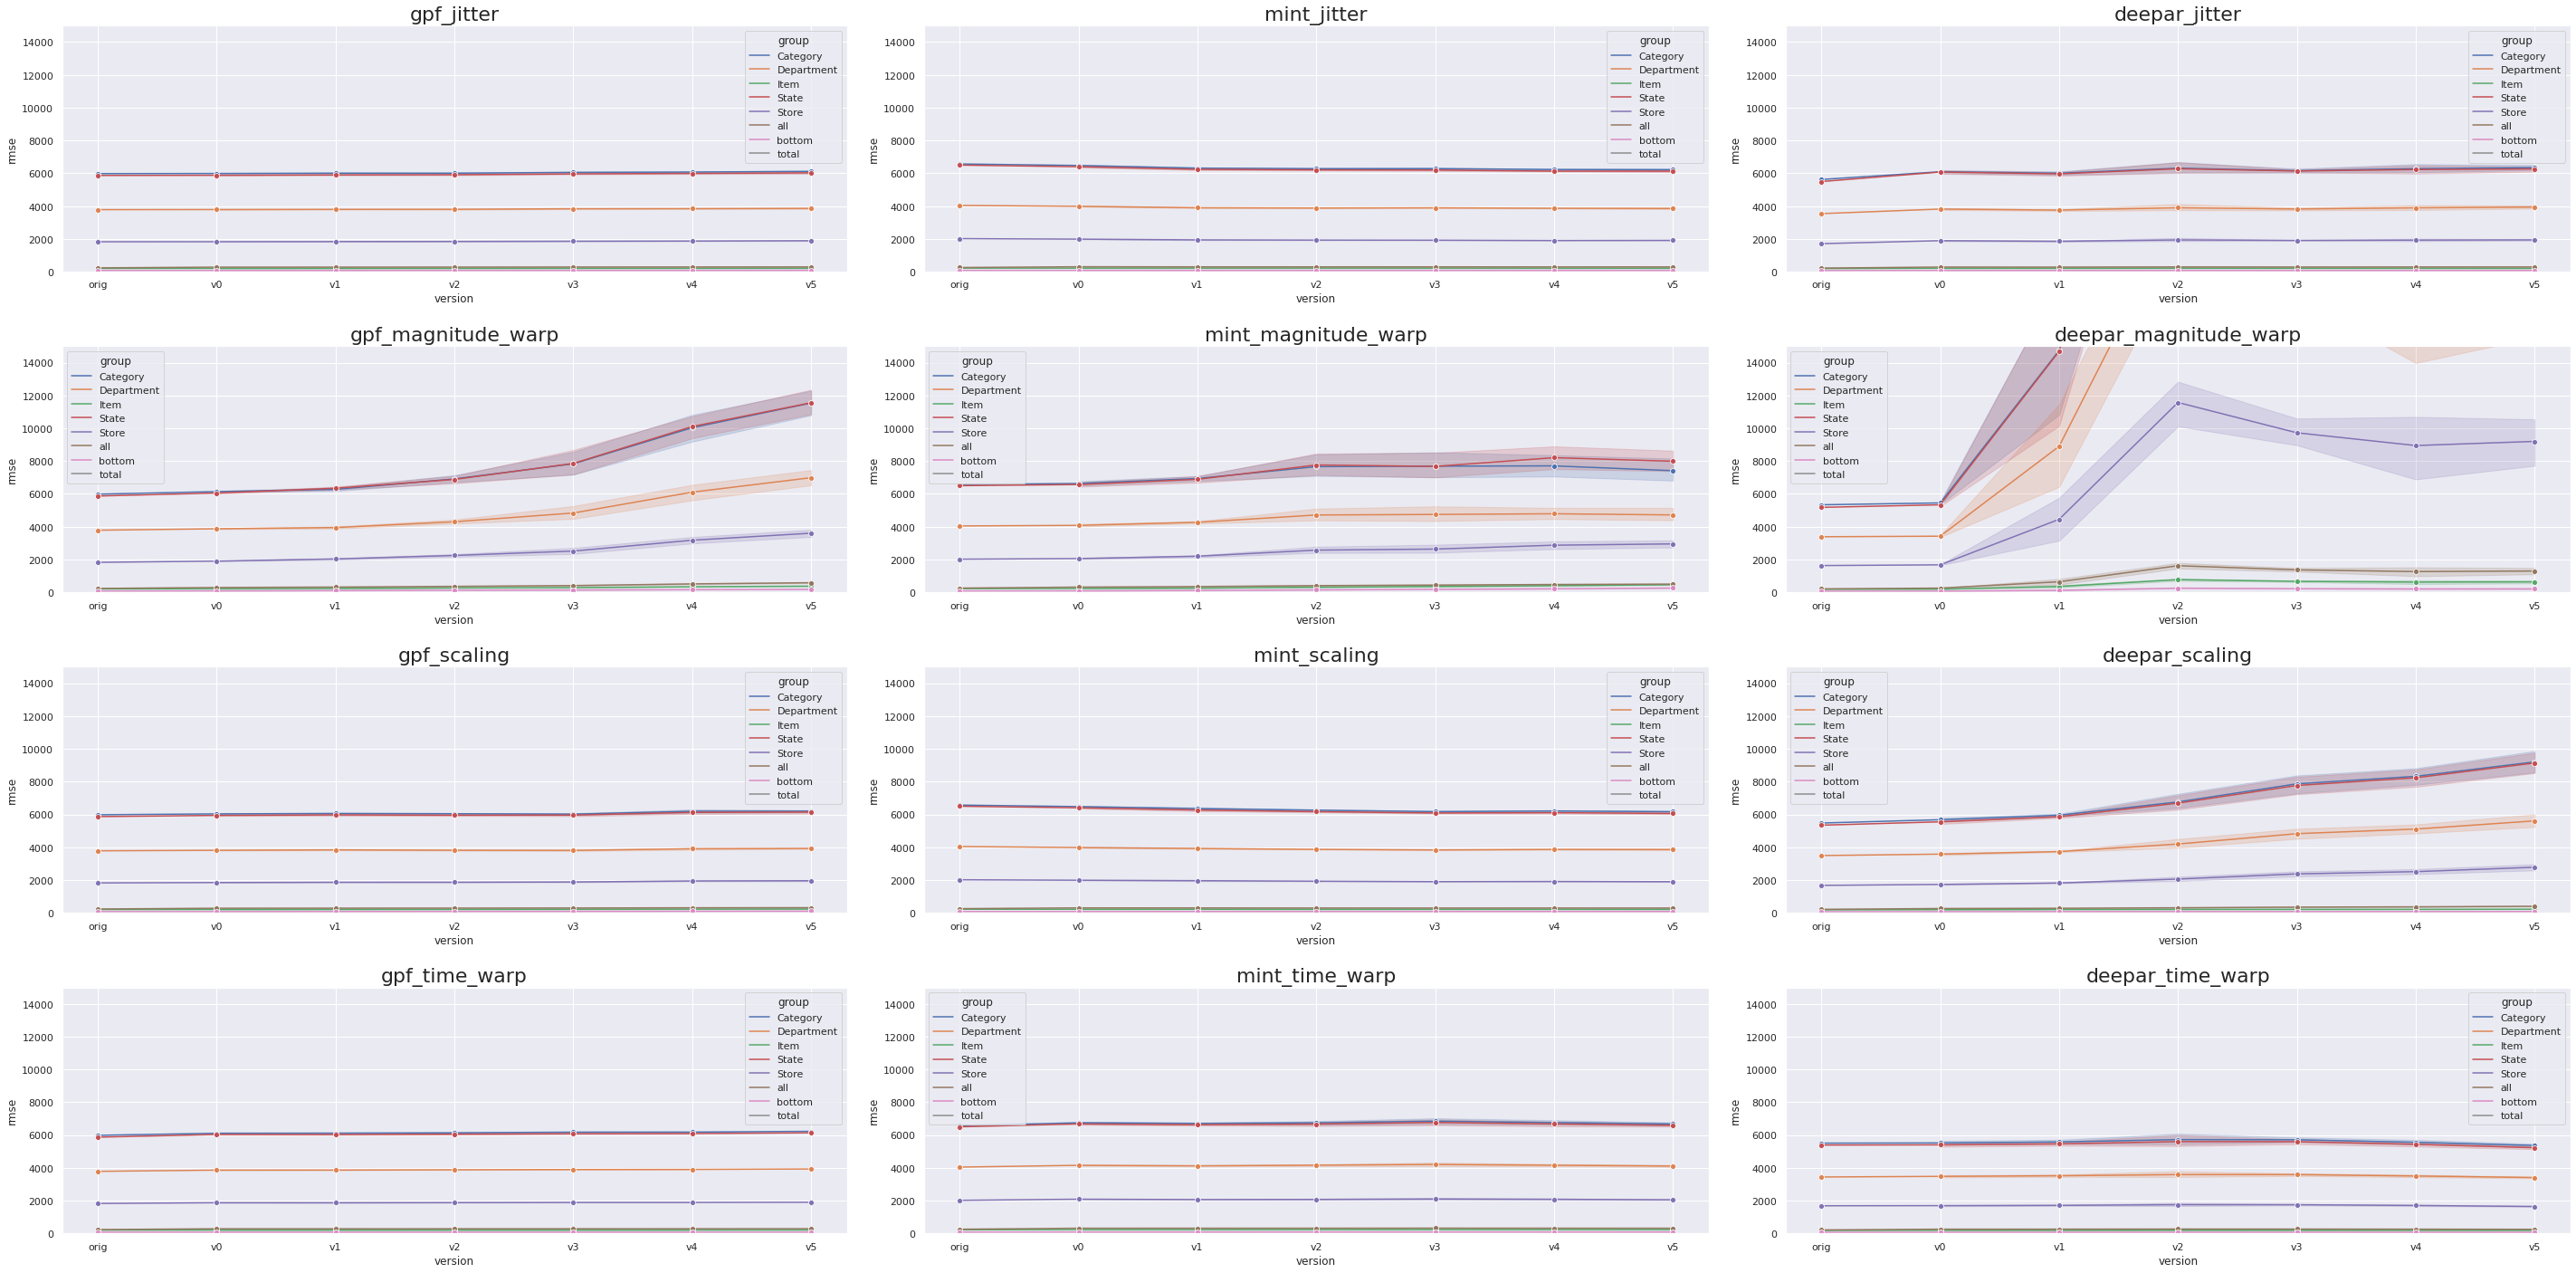

In [35]:
plot_results_joint(df_gpf_rmse, df_mint_rmse, df_deepar_rmse, 'rmse')

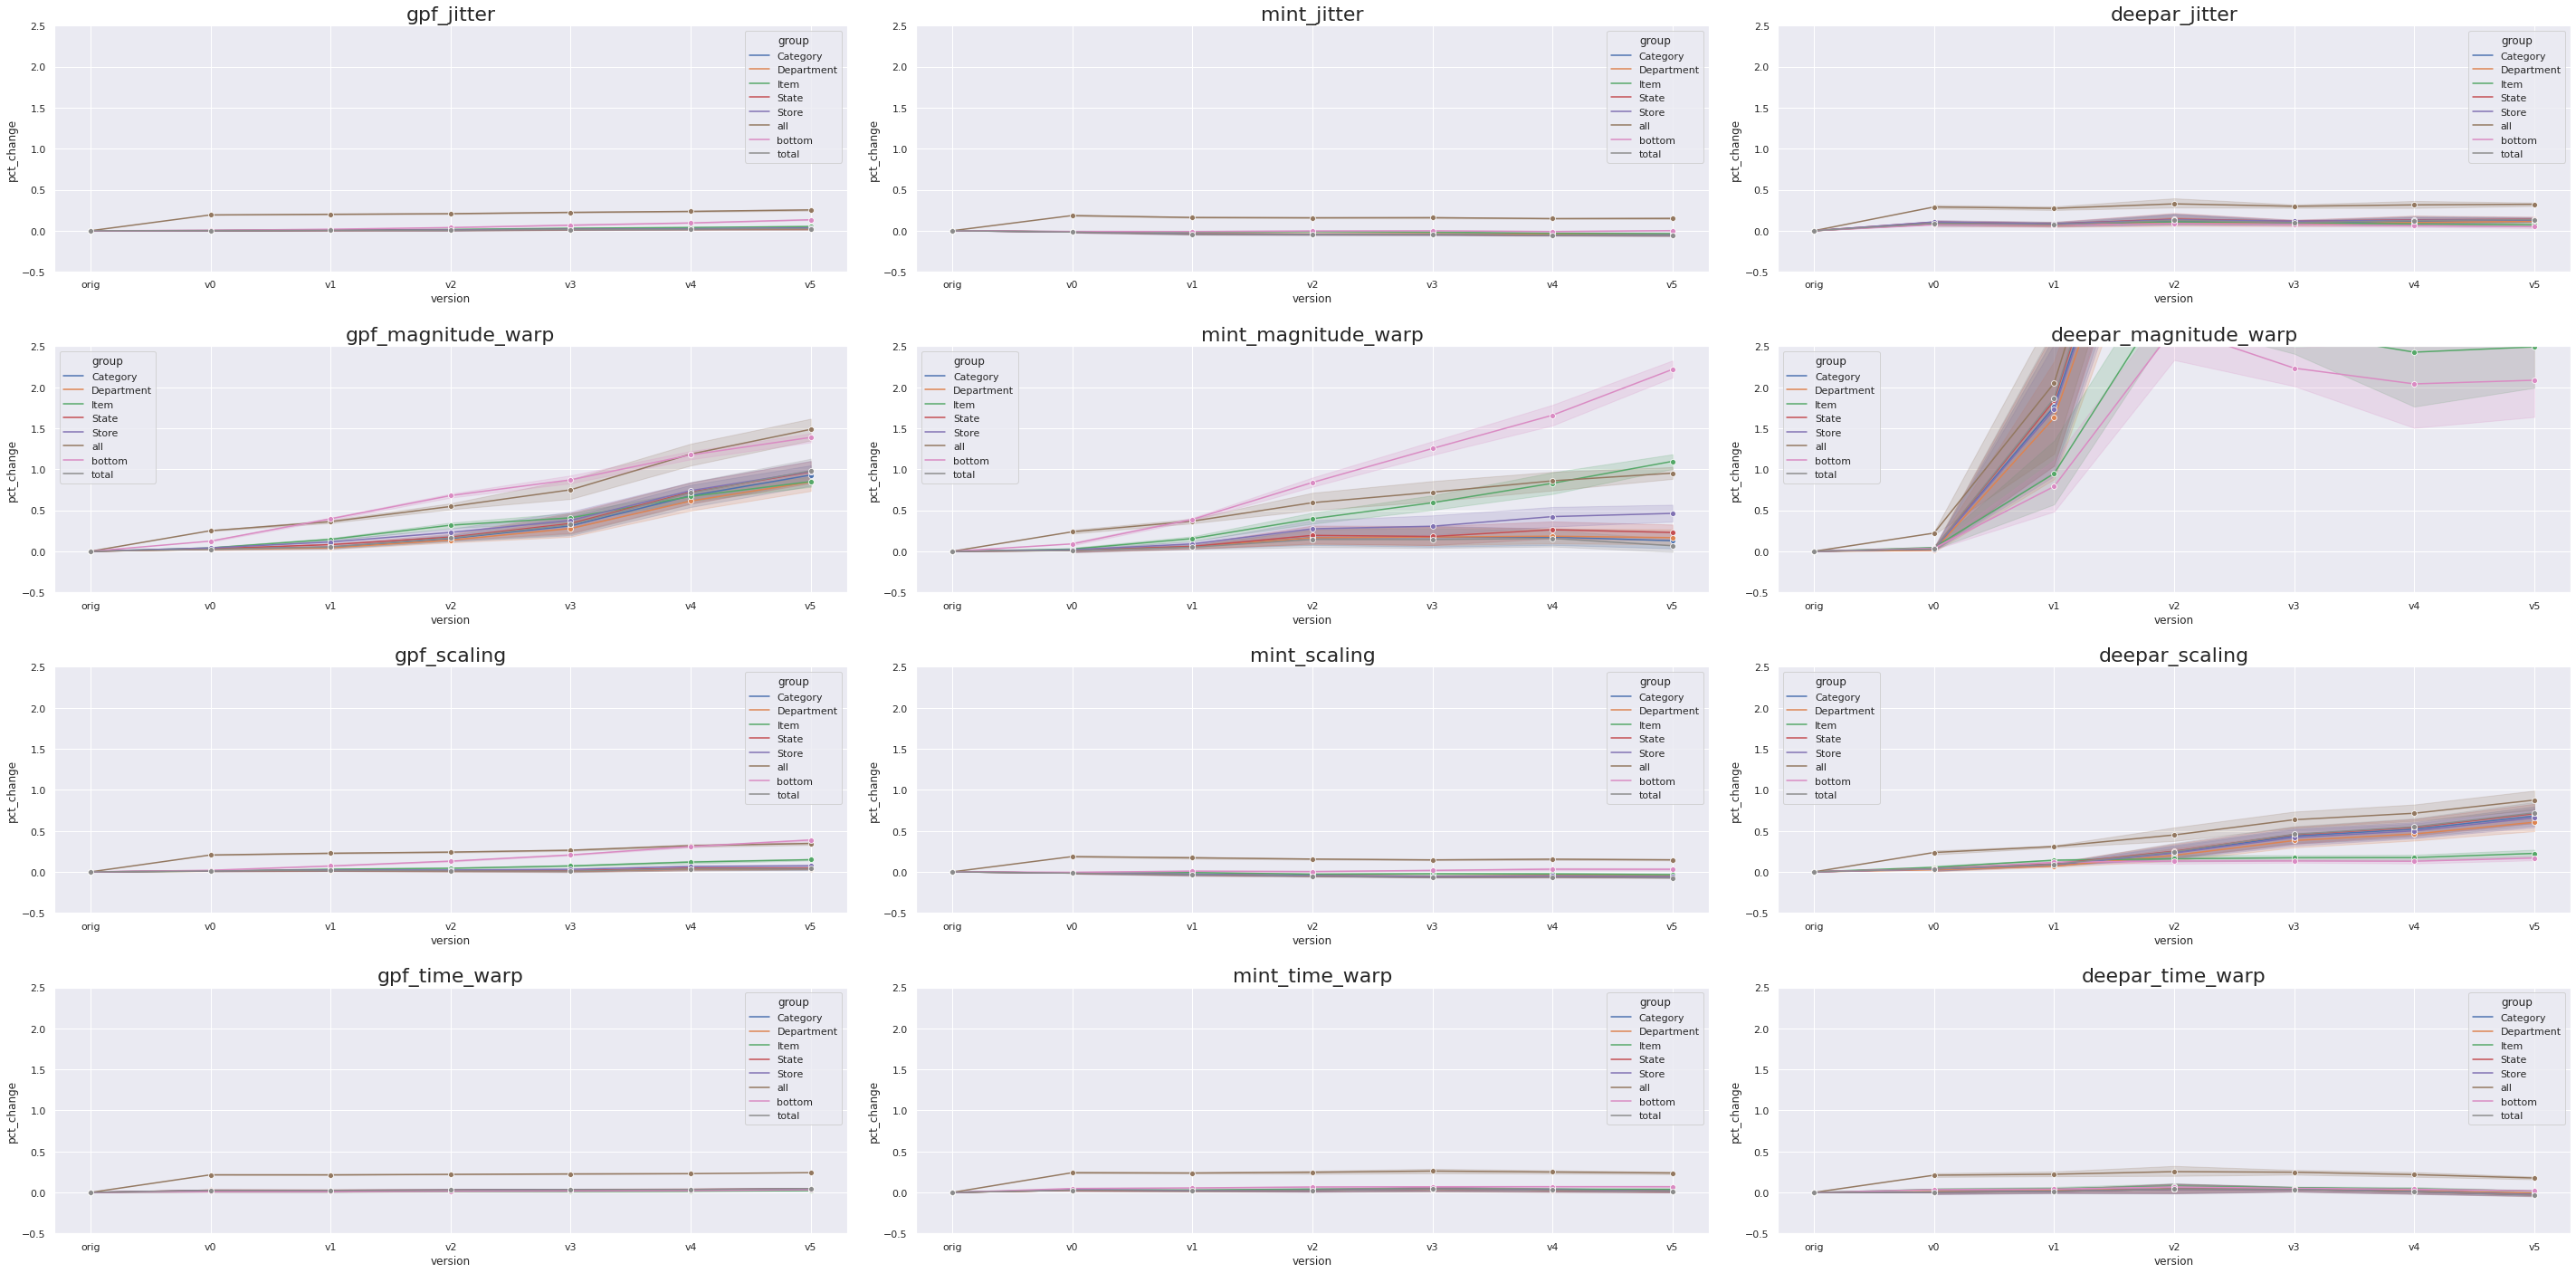

In [36]:
plot_results_joint(df_gpf_rmse, df_mint_rmse, df_deepar_rmse, 'pct_change')